In [1]:
import importlib
import sys
from urllib.request import urlretrieve


# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from sympy import Matrix

import pydrake.all

# pydrake imports
from pydrake.common.containers import namedview
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.all import (Variable, SymbolicVectorSystem, VectorSystem, DiagramBuilder,
                         LogOutput, Simulator, ConstantVectorSource,
                         MathematicalProgram, Solve, SnoptSolver, PiecewisePolynomial, eq, cos, sin, 
                         DirectTranscription, DirectCollocation)
from pydrake.all import (FiniteHorizonLinearQuadraticRegulator,  MakeFiniteHorizonLinearQuadraticRegulator)

from pydrake.systems.framework import (BasicVector, BasicVector_, LeafSystem_,
                                       LeafSystem)
import pydrake.symbolic as sym

from lyapunov_control import *
from trajopt_control import *
from robust_trajopt import *

# Matplotlib parameters
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 3


In [2]:
close_i = 0
def get_cost_from_traj(x_traj, u_traj, T, xf, r):
    """
    Gets cost from trajectory of shape (2, x) and reference input of shape (1, x)
    """
    num_steps = np.shape(x_traj)[1]
    dt = 0.1
    control_cost = 0
    time_cost = 0
    close_i = 0
    
    for i in range(num_steps-1):
        # Add control cost IF the trajectory not circling around final point
        p = x_traj[:2, i] - xf[:2]
        if np.abs(p.dot(p) - r**2) > 0.5:
            control_cost += u_traj[0,i]*u_traj[0,i]*dt
            time_cost += dt
        else:
            if close_i == 0:
                close_i = i

    return np.array([control_cost, time_cost, close_i])
        # Add state cos

# Lyapunov Controller Demonstration

The below code demonstrates the Lyapunov controller at $\mathbf{x_0} = [10, 0, \pi - 0.2]$. 

[ 30.62603325 150.1        332.        ]


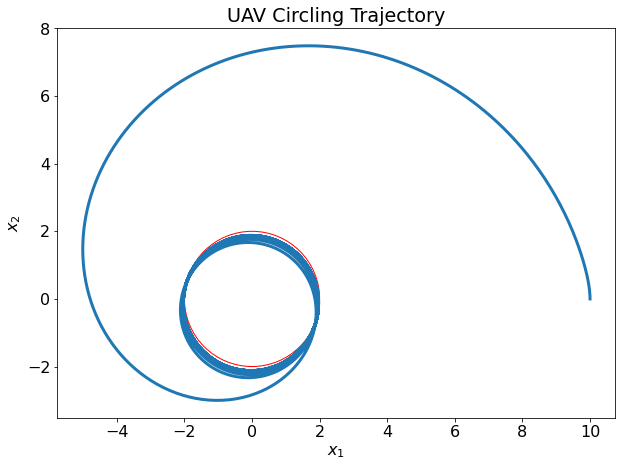

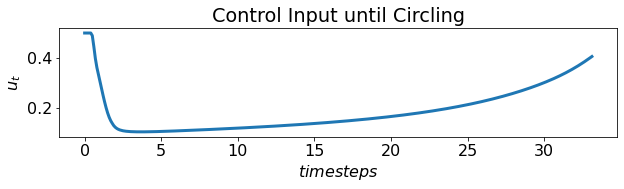

In [3]:
x0 = np.array([10., 0., np.pi/2.])
xf = np.array([0., 0., 0.])
T = 400 
r = 2.
u_max = 0.5

# Run the Lyapunov Simulation
simulator, traj, control = lyapunov_simulation(x0, xf)
time_scale = simulator.get_actual_realtime_rate() # get the rate of simulation

# Draw the results
draw_simulation(traj, xf, 2)
lyapunov_cost = get_cost_from_traj(traj[:2,:], control, T*time_scale, xf, r) # Gets the cost in the forms control_cost, time_cost
print(lyapunov_cost)
plot_input(control.T, int(lyapunov_cost[2]), time_scale=time_scale)

# Trajectory Optimization

This code runs a trajectory optimization, draws the trajectory, and pulls the cost from the trajetory.

Control Cost: 6.53180987690189
Time Cost: 30.600000000000165
Index to circling: 94.0


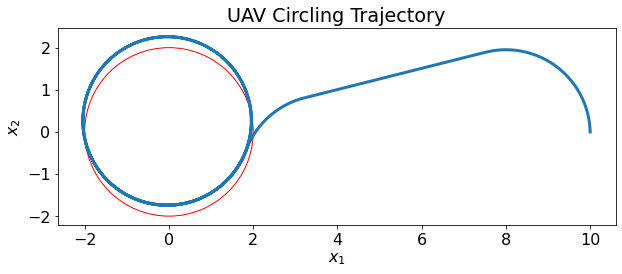

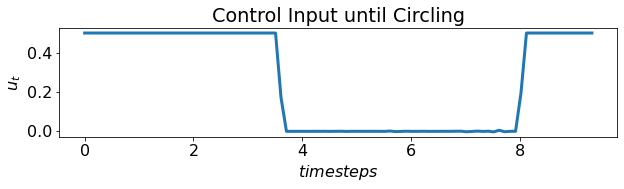

In [4]:
x_opt, u_opt = trajopt_simulation(x0, xf, 0.5) # simulate from initial point (x0) to final point (xf)
draw_simulation(x_opt, xf, 2) # draw simulation
control = u_opt.reshape(np.shape(u_opt)[0], 1) # get and reshape control input
opt_cost = get_cost_from_traj(x_opt, control.T, T, xf, r) # gets cost
# cost form: control
print("Control Cost: " + str(opt_cost[0]))
print("Time Cost: " + str(opt_cost[1]))
print("Index to circling: " + str(opt_cost[2]))
plot_input(u_opt, int(opt_cost[2])) # plots input

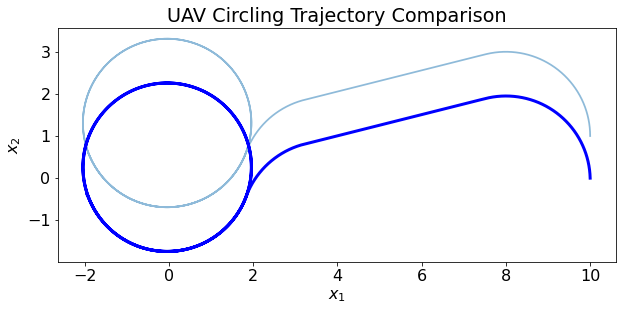

In [5]:
x0 = np.array([10, 1, np.pi/2.])
x_traj = np.zeros((3, 0))

for i in range(np.shape(x_opt)[1]-1):
    u_ref = u_opt[i]
    simulator, data, control_data = simulation(x0, u_ref)
    x_traj = np.concatenate((x_traj, data), axis=1)
    x0 = data[:,-1]

draw_comparison(x_opt, np.array([x_traj]))


# Robust Trajectory Optimization

Below, we generate some trajectories with disturbed initial states. We compare the robust trajectory optimization algorithm (with modified CLF) to one that simply aplpies the control input from the trajectory optimization.

In [6]:
dt = 0.1
k = 1
x0 = np.array([10, 0, np.pi/2.-0.2])
xf = np.array([0, 0, 0])
T = 400 
r = 2
x_traj = np.zeros(np.shape(x_opt))
x_trajectories = []
robust_u_trajectories = []
robust_costs = []

x_disturbed_trajectories = []
disturbed_costs = []


# plt.figure(figsize=(15, 15))

# Generate variety of "disturbed" starting points
starting_points = []
for j in range(5):
    starting_points.append(x0 + np.random.rand(1, 3)*0.5)
    starting_points.append(x0 - np.random.rand(1, 3)*0.5)

# Visualize the performance of these disturbed trajectories
for x0 in starting_points:
    close = False
    x0 = x0[0]
    
    x_traj, u_traj = robust_trajopt(x_opt, u_opt, x0)
    x_trajectories.append(x_traj[:,:-2])
    robust_u_trajectories.append(u_traj)
    robust_costs.append(get_cost_from_traj(x_traj, u_traj.reshape(np.shape(u_traj)[0], 1).T, T, xf, r))
    
    x_traj_disturbed = np.zeros((3, 0))
    u_traj_disturbed = np.zeros((1, 0))
    
    for j in range(np.shape(x_opt)[1]-1):
        u_ref = u_opt[j]
        simulator, data, control_data = simulation(x0, u_ref)
        x_traj_disturbed = np.concatenate((x_traj_disturbed, data), axis=1)
        u_traj_disturbed = np.concatenate((u_traj_disturbed, control_data), axis=1)
        x0 = data[:,-1]
    x_disturbed_trajectories.append(x_traj_disturbed[:,:-2])
    disturbed_costs.append(get_cost_from_traj(x_traj_disturbed, u_traj_disturbed, T, xf, r))

As you can see, the robust trajectory optimization does a great job of tracking the long-term behavior of the system, though it is oscillatory and overshoots at the beginning. This is because our system actually _can't_ stabilize to a fixed position, so it's interesting to see the CLF concept verified for severely underactuated systems.

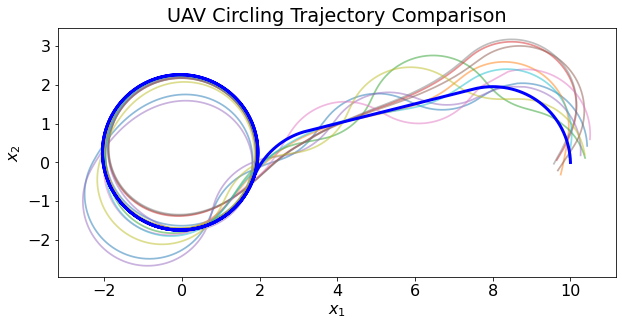

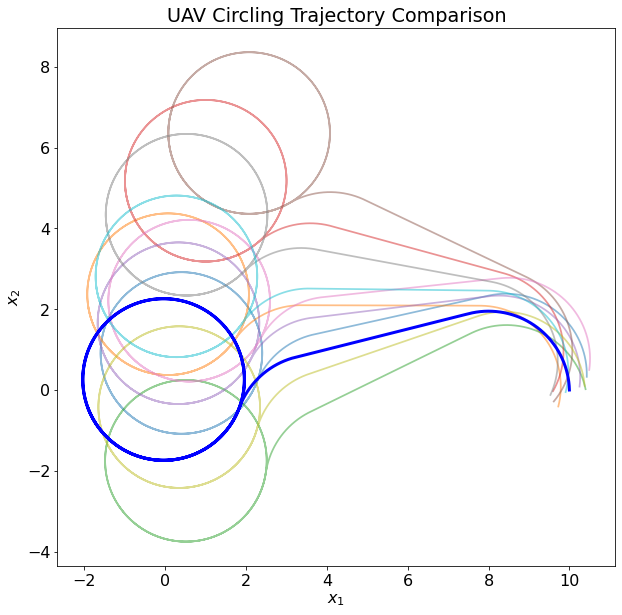

In [7]:
draw_comparison(x_opt[:,:-1], x_trajectories)
draw_comparison(x_opt[:,:-1], x_disturbed_trajectories)

# Cost Comparisons

Here, we explore the control and time costs for each trial, as well as their averages vs. the optimal and Lyapunov control. Generally, the robust mCLF performs close to optimally in terms of cost, which is pretty cool!

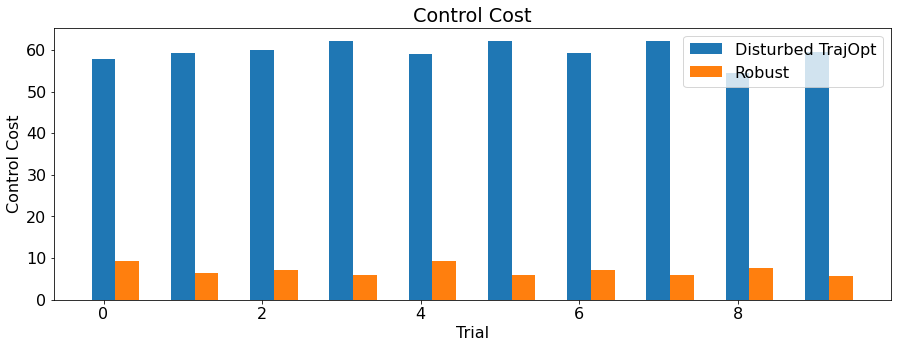

In [8]:
disturbed_costs = np.array(disturbed_costs)
robust_costs = np.array(robust_costs)

costs = []
for i in range(len(disturbed_costs)):
    costs.append(disturbed_costs[i])
    costs.append(robust_costs[i])
    
# Numbers of pairs of bars you want
N = 10

###
# PLOT CONTROL COST
###
# Data on X-axis
# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(15,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, disturbed_costs[:,0] , width, label='Disturbed TrajOpt')
plt.bar(ind + width, robust_costs[:,0], width, label='Robust')

plt.xlabel('Trial')
plt.ylabel('Control Cost')
plt.title('Control Cost')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
# plt.xticks(ind + width / 2, ('Xtick1', 'Xtick3', 'Xtick3'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()


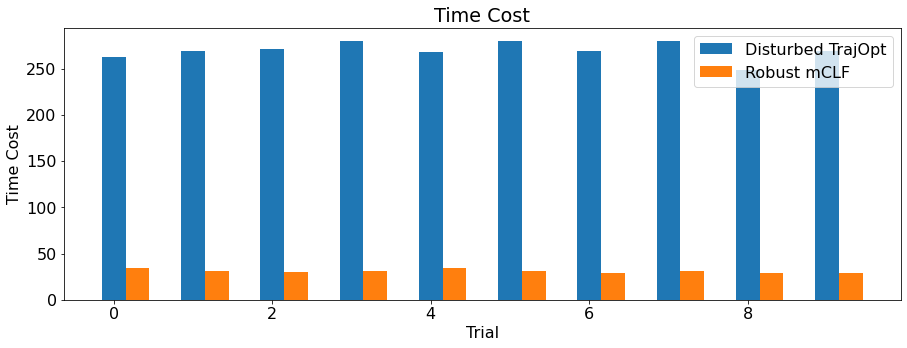

In [9]:
###
# PLOT TIME COST
### 
# Data on X-axis
# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(15,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, disturbed_costs[:,1] , width, label='Disturbed TrajOpt')
plt.bar(ind + width, robust_costs[:,1], width, label='Robust mCLF')

plt.xlabel('Trial')
plt.ylabel('Time Cost')
plt.title('Time Cost')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
# plt.xticks(ind + width / 2, ('Xtick1', 'Xtick3', 'Xtick3'))

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()

150.09999999999576


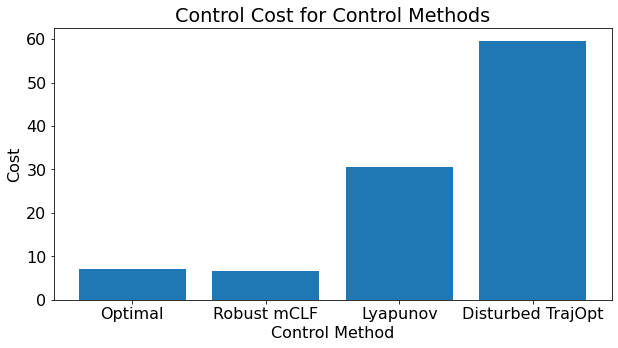

In [10]:
dc_avg = np.average(disturbed_costs[:,0])
rc_avg = np.average(robust_costs[:,0])
print(lyapunov_cost[1])

###
# PLOT CONTROL AVERAGES
###
# Data on X-axis
# Position of bars on x-axis
N = 3
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

x = ['Optimal','Robust mCLF', 'Lyapunov', 'Disturbed TrajOpt']
energy = [rc_avg, opt_cost[0], lyapunov_cost[0], dc_avg]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy)
plt.xlabel("Control Method")
plt.ylabel("Cost")
plt.title("Control Cost for Control Methods")

plt.xticks(x_pos, x)

plt.show()


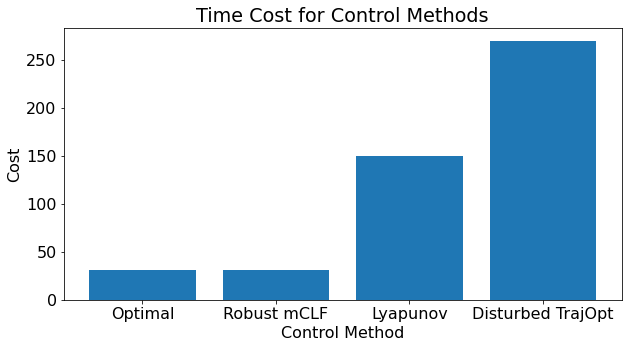

In [11]:
dc_avg = np.average(disturbed_costs[:,1])
rc_avg = np.average(robust_costs[:,1])

###
# PLOT CONTROL AVERAGES
###
# Data on X-axis
# Position of bars on x-axis
N = 3
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

x = ['Optimal','Robust mCLF', 'Lyapunov', 'Disturbed TrajOpt']
energy = [opt_cost[1], rc_avg, lyapunov_cost[1], dc_avg]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy)
plt.xlabel("Control Method")
plt.ylabel("Cost")
plt.title("Time Cost for Control Methods")

plt.xticks(x_pos, x)

plt.show()

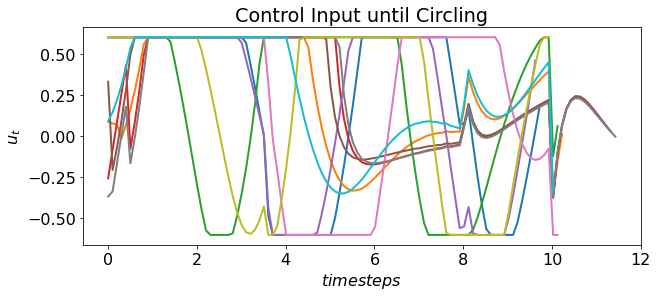

In [12]:
robust_costs = np.array(robust_costs)
close_is = robust_costs[:,2]
plot_inputs(robust_u_trajectories, close_is)